In [142]:
run_number     = 4264
save_plots     = False
outputfolder   = "plots/{}/".format(run_number)
corr_filename  = "/Users/Gonzalo/github/NEXTdata/corrections/run4150_corrections.h5"
inputfilename  = "/Users/Gonzalo/github/NEXTdata/Na22/{0}/pmaps.gdcsnext.000_{0}.root.h5".format(run_number)

rebin_S2       = 3
select         = "PE"
n_events       = 10

XRrange        = 4500,  1e4
PErange        = 10e4, 20e4

In [143]:
import os
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.database.load_db         as db
import invisible_cities.core    .exceptions      as excp
import invisible_cities.core    .core_functions  as coref
import invisible_cities.core    .fit_functions   as fitf
import invisible_cities.reco    .dst_functions   as dstf
import invisible_cities.reco    .pmaps_functions as pmpf
import invisible_cities.reco    .dst_io          as dstio
import invisible_cities.reco    .corrections     as corrf
import invisible_cities.reco    .xy_algorithms   as reco


from icaro.core.hst_functions import hist
from icaro.core.hst_functions import hist2d
from icaro.core.hst_functions import pdf
from icaro.core.hst_functions import labels
from icaro.core.hst_functions import hist2d_profile
from icaro.core.hst_functions import covariance
from icaro.core.hst_functions import resolution
from icaro.core.hst_functions import gausstext
from icaro.core.hst_functions import shift_to_bin_centers
from icaro.core.hst_functions import save_to_folder

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Thu Jun  8 17:49:52 2017


In [144]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
XR1Opt  = "k"
XR2Opt  = "c"
BkgOpt  = "m"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

In [148]:
def plot_grid(XYcorr):
    x, y  = XYcorr._xs
    xbins = np.concatenate([x, [x[-1] + np.diff(x)[0]]])
    ybins = np.concatenate([y, [y[-1] + np.diff(y)[0]]])

    x, y  = np.repeat(x, y.size), np.tile(y, x.size)
    f     = XYcorr._fs.flatten()

    plt.hist2d(x, y, bins=(xbins, ybins), weights=f)
    plt.gca().set_xticks(xbins, minor=True)
    plt.gca().set_yticks(ybins, minor=True)
    plt.grid(which="minor")
    labels("x (mm)", "y (mm)")


def select_slices(si, i0, i1):
    d = dict(si)
    for sipm in d:
        d[sipm] = np.sum(si[sipm][i0:i1])
    return d

def plot_evt(Si, rebin=rebin_S2):
    x, y, q = [], [], []
    for peak in Si.values():
        nslices = len(next(iter(peak.values())))
        for i in range(int(np.ceil(nslices/rebin))):
            sipms   = select_slices(peak, i, i+rebin)
            IDs, Qs = map(list, zip(*sipms.items()))
            xs, ys  = DataSiPM.X.values[IDs], DataSiPM.Y.values[IDs]
            try:
                b = reco.barycenter(np.stack([xs, ys], axis=1), Qs)
                x.append(b.pos[0])
                y.append(b.pos[1])
                q.append(b.Q     )
            except excp.SipmZeroCharge:
                pass
    plt.scatter(x, y, s=np.array(q)/100, c="k")
    return

def filter_evts(S1, S2, Si, opt=None):
    evts = list(set(S2PMT.keys() & set(S2SiPM.keys())))
    if not opt: return evts
    
    if opt in ["PE", "XR"]:
        lims = PErange if opt=="PE" else XRrange
        for i in reversed(range(len(evts))):
            s2 = S2[evts[i]]
            if not filter(lambda peak: coref.in_range(peak.E.sum(), *lims), s2.values()):
                evts.pop(i)
    return evts

In [149]:
XYcorr = dstf.load_xy_corrections(corr_filename)
DataSiPM = db.DataSiPM()

S1, S2PMT, S2SiPM = pmpf.load_pmaps(inputfilename)
evts = filter_evts(S1, S2PMT, S2SiPM, select)

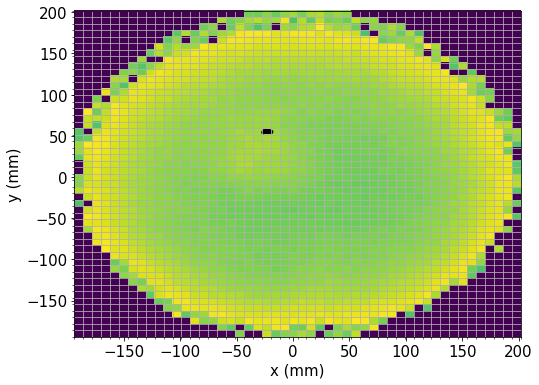

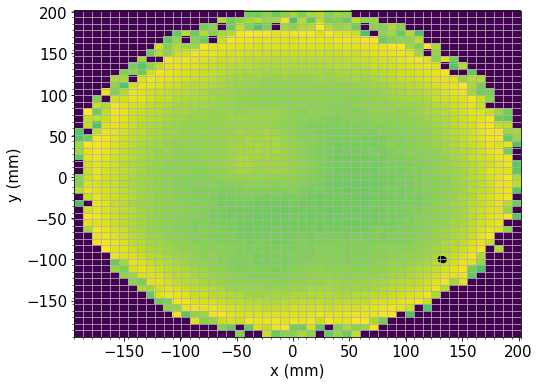

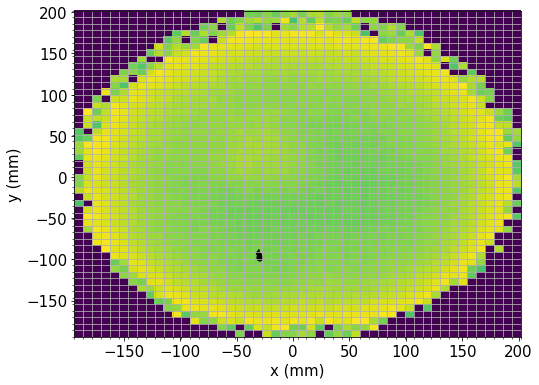

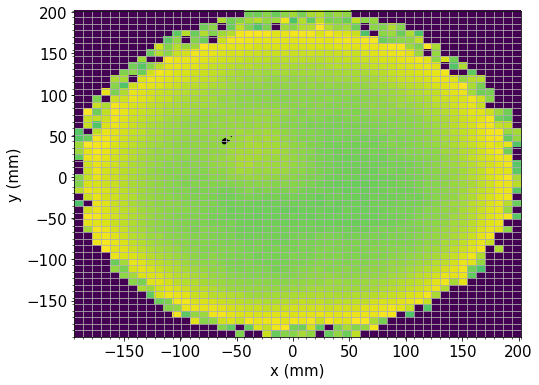

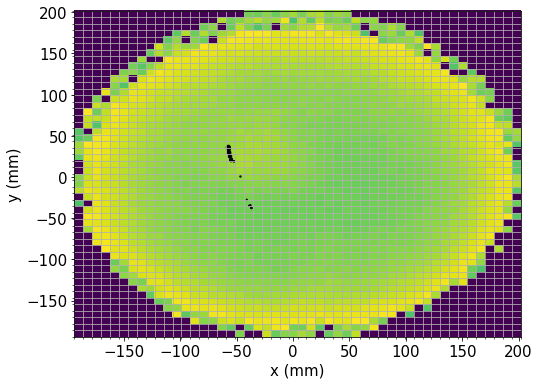

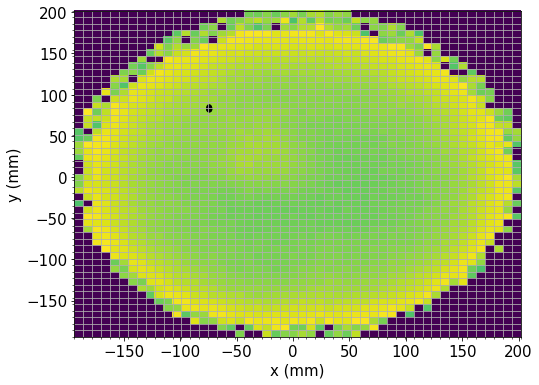

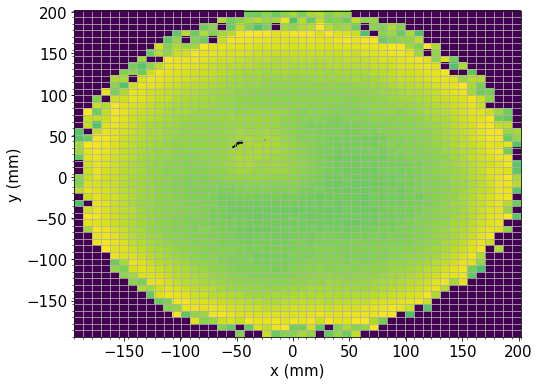

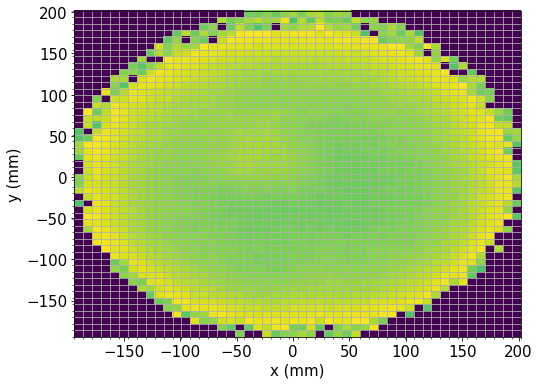

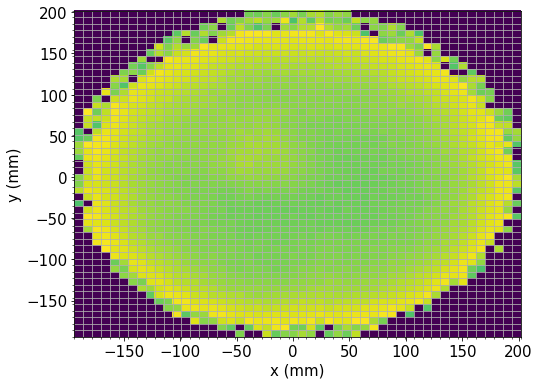

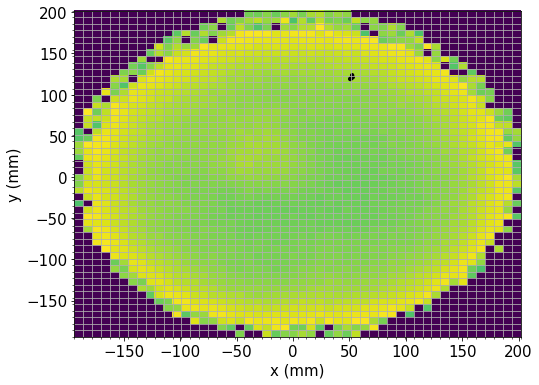

In [150]:
for i in range(n_events):
    plt.figure()
    plot_grid(XYcorr)
    plot_evt(S2Si[evts[i]], rebin_S2)